## Data Preparation

### Getting data from yfinance

In [293]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import numpy as np
import os
import json

import pandas as pd
from sklearn.preprocessing import StandardScaler
import ta

import yfinance as yf


config = {
    "yfinance": {
        "symbol": "^GSPC",
        "period": "10y",
        "interval": "1d",
    },
    "data": {
        "window_size": 20, # use information from past 20 days to predict
        "train_split_size": 0.70,
        "val_split_size": 0.15,
        "test_split_size": 0.15,
    }, 
    "plots": {
        "xticks_interval": 40,
        "color_actual": "#ff8000",
        "color_train": "#58F6AF",
        "color_val": "#7CC2FF",
        "color_test": "#FF6464",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#00529A",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 7,
        "num_lstm_layers": 2,
        "lstm_size": 32, # hidden state dimensionality
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 1e-2,
        "weight_decay": 1e-2,
        "scheduler_step_size": 40,
    }
}

In [123]:
json_file = f"stock_data_{config["yfinance"]["symbol"]}.json"

sp500 = yf.Ticker(config["yfinance"]["symbol"])


raw_data = sp500.history(period = config["yfinance"]["period"],
                         interval = config["yfinance"]["interval"], 
                         auto_adjust = True, # we want OHLC adjusted for dividends/stock splits
                         actions = False) # exclude the dividends/splits data
raw_data = raw_data.reset_index()
raw_data

,Date,Open,High,Low,Close,Volume
0,2015-08-24 00:00:00-04:00,1965.150024,1965.150024,1867.010010,1893.209961,6612690000
1,2015-08-25 00:00:00-04:00,1898.079956,1948.040039,1867.079956,1867.609985,5183560000
2,2015-08-26 00:00:00-04:00,1872.750000,1943.089966,1872.750000,1940.510010,5338250000
3,2015-08-27 00:00:00-04:00,1942.770020,1989.599976,1942.770020,1987.660034,5006390000
4,2015-08-28 00:00:00-04:00,1986.060059,1993.479980,1975.189941,1988.869995,3949080000
...,...,...,...,...,...,...
2510,2025-08-18 00:00:00-04:00,6445.020020,6455.350098,6437.700195,6449.149902,4162290000
2511,2025-08-19 00:00:00-04:00,6446.240234,6456.479980,6400.220215,6411.370117,4377440000
2512,2025-08-20 00:00:00-04:00,6406.620117,6408.399902,6343.859863,6395.779785,4470390000
2513,2025-08-21 00:00:00-04:00,6380.830078,6393.649902,6352.709961,6370.169922,4013560000


In [134]:
raw_data["Date"] = pd.to_datetime(raw_data["Date"]).dt.strftime("%Y-%m-%d")
raw_data.to_json(json_file, orient="records", indent=4, date_format="iso")

In [263]:
with open(json_file, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df

,Date,Open,High,Low,Close,Volume
0,2015-08-24,1965.150024,1965.150024,1867.010010,1893.209961,6612690000
1,2015-08-25,1898.079956,1948.040039,1867.079956,1867.609985,5183560000
2,2015-08-26,1872.750000,1943.089966,1872.750000,1940.510010,5338250000
3,2015-08-27,1942.770020,1989.599976,1942.770020,1987.660034,5006390000
4,2015-08-28,1986.060059,1993.479980,1975.189941,1988.869995,3949080000
...,...,...,...,...,...,...
2510,2025-08-18,6445.020020,6455.350098,6437.700195,6449.149902,4162290000
2511,2025-08-19,6446.240234,6456.479980,6400.220215,6411.370117,4377440000
2512,2025-08-20,6406.620117,6408.399902,6343.859863,6395.779785,4470390000
2513,2025-08-21,6380.830078,6393.649902,6352.709961,6370.169922,4013560000


### Compute technical indicators

In [264]:
df["SMA_10"] = df["Close"].rolling(10).mean()
df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()
df["RSI_14"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()
macd = ta.trend.MACD(df["Close"])
df["MACD_diff"] = macd.macd_diff()
df["ATR_14"] = ta.volatility.AverageTrueRange(
    high=df["High"], low=df["Low"], close=df["Close"], window=14
).average_true_range()

df = df.iloc[35:].reset_index(drop=True)
df

,Date,Open,High,Low,Close,Volume,SMA_10,EMA_20,RSI_14,MACD_diff,ATR_14
0,2015-10-13,2015.000000,2022.339966,2001.780029,2003.689941,3401920000,1980.747998,1969.331728,60.518915,8.617635,31.137945
1,2015-10-14,2003.660034,2009.560059,1990.729980,1994.239990,3644590000,1988.168994,1971.703944,57.777451,6.521371,30.258812
2,2015-10-15,1996.469971,2024.150024,1996.469971,2023.859985,3746290000,1998.172998,1976.671186,63.377362,6.643171,30.233899
3,2015-10-16,2024.369995,2033.540039,2020.459961,2033.109985,3595430000,2006.347998,1982.046310,64.941142,6.833720,29.008626
4,2015-10-19,2031.729980,2034.449951,2022.310059,2033.660034,3287320000,2011.008997,1986.961902,65.036748,6.486584,27.803717
...,...,...,...,...,...,...,...,...,...,...,...
2475,2025-08-18,6445.020020,6455.350098,6437.700195,6449.149902,4162290000,6402.697998,6371.183968,64.955221,2.459335,51.972821
2476,2025-08-19,6446.240234,6456.479980,6400.220215,6411.370117,4377440000,6413.916016,6375.011220,58.861329,-1.280983,52.279031
2477,2025-08-20,6406.620117,6408.399902,6343.859863,6395.779785,4470390000,6418.987988,6376.989179,56.505458,-5.084214,53.366976
2478,2025-08-21,6380.830078,6393.649902,6352.709961,6370.169922,4013560000,6422.004980,6376.339726,52.769186,-9.355339,52.631465


In [265]:
data_dates = df["Date"].tolist()
num_data_points = len(df)
display_date_range = f"from {data_dates[0]} to {data_dates[-1]}"

print("Number of data points:", num_data_points, display_date_range)
df.head()

Number of data points: 2480 from 2015-10-13 to 2025-08-22


,Date,Open,High,Low,Close,Volume,SMA_10,EMA_20,RSI_14,MACD_diff,ATR_14
0,2015-10-13,2015.000000,2022.339966,2001.780029,2003.689941,3401920000,1980.747998,1969.331728,60.518915,8.617635,31.137945
1,2015-10-14,2003.660034,2009.560059,1990.729980,1994.239990,3644590000,1988.168994,1971.703944,57.777451,6.521371,30.258812
2,2015-10-15,1996.469971,2024.150024,1996.469971,2023.859985,3746290000,1998.172998,1976.671186,63.377362,6.643171,30.233899
3,2015-10-16,2024.369995,2033.540039,2020.459961,2033.109985,3595430000,2006.347998,1982.046310,64.941142,6.833720,29.008626
4,2015-10-19,2031.729980,2034.449951,2022.310059,2033.660034,3287320000,2011.008997,1986.961902,65.036748,6.486584,27.803717


### Visualize

In [266]:
features = ["Close", "SMA_10", "EMA_20", "MACD_diff", "ATR_14", "Volume", "RSI_14"]
df_features = df[features]
df_features

,Close,SMA_10,EMA_20,MACD_diff,ATR_14,Volume,RSI_14
0,2003.689941,1980.747998,1969.331728,8.617635,31.137945,3401920000,60.518915
1,1994.239990,1988.168994,1971.703944,6.521371,30.258812,3644590000,57.777451
2,2023.859985,1998.172998,1976.671186,6.643171,30.233899,3746290000,63.377362
3,2033.109985,2006.347998,1982.046310,6.833720,29.008626,3595430000,64.941142
4,2033.660034,2011.008997,1986.961902,6.486584,27.803717,3287320000,65.036748
...,...,...,...,...,...,...,...
2475,6449.149902,6402.697998,6371.183968,2.459335,51.972821,4162290000,64.955221
2476,6411.370117,6413.916016,6375.011220,-1.280983,52.279031,4377440000,58.861329
2477,6395.779785,6418.987988,6376.989179,-5.084214,53.366976,4470390000,56.505458
2478,6370.169922,6422.004980,6376.339726,-9.355339,52.631465,4013560000,52.769186


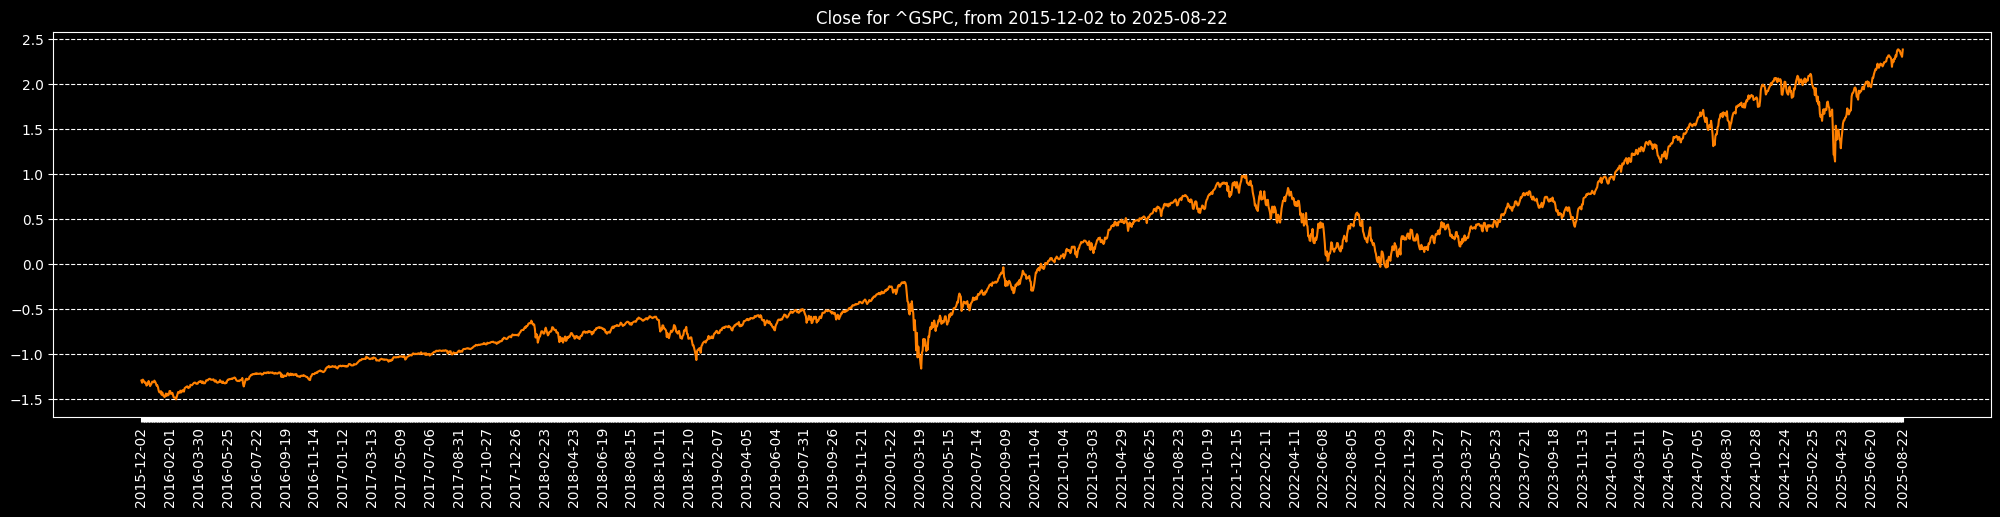

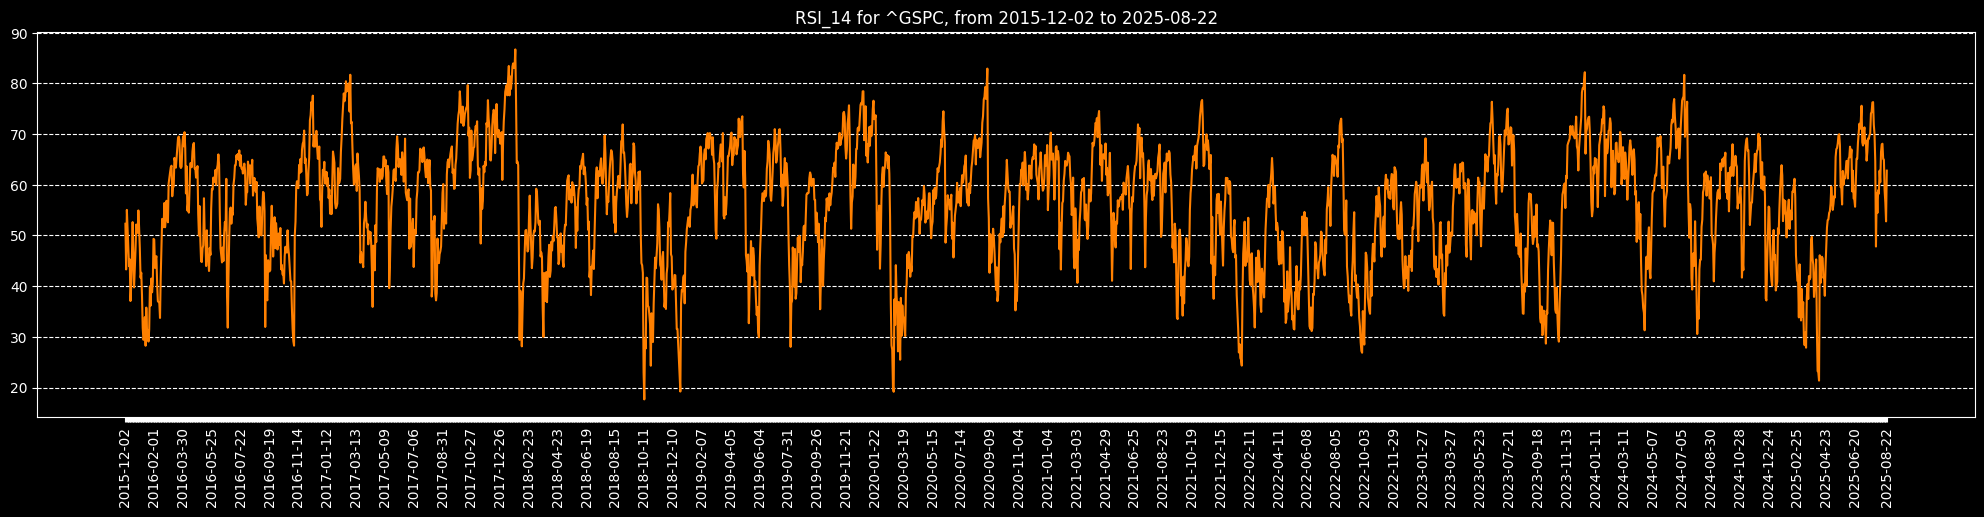

In [203]:
plt.style.use("dark_background")

def plot_feature(data_dates, df, feature, num_data_points, display_date_range):
    fig = plt.figure(figsize=(25, 5), dpi=100)
    fig.patch.set_facecolor(color="black")

    plt.plot(data_dates, df[feature].to_list(), color=config["plots"]["color_actual"])

    xticks_labels = []
    xticks_interval = config["plots"]["xticks_interval"]

    for i in range(num_data_points):
        # Always include the last data point
        if i == num_data_points - 1:
            xticks_labels.append(data_dates[i])
        # Include every xticks_interval-th point, but avoid ticks too close to the end
        elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
            xticks_labels.append(data_dates[i])
        else:
            xticks_labels.append(None)

    xticks_indices = np.arange(0, len(xticks_labels))
    plt.xticks(xticks_indices, xticks_labels, rotation="vertical")

    plt.title(f"{feature} for {config["yfinance"]["symbol"]}, {display_date_range}")
    plt.grid(axis="y", linestyle="--")

plot_feature(data_dates, df_features, "Close", num_data_points, display_date_range)
plot_feature(data_dates, df_features, "RSI_14", num_data_points, display_date_range)

### Normalizing raw data

In [267]:
unbounded = ["Close", "SMA_10", "EMA_20", "MACD_diff", "ATR_14", "Volume"]

scaler = StandardScaler()

df_scaled_features = scaler.fit_transform(df[unbounded])

np_rsi = (df_features["RSI_14"].to_numpy() / 100.0).reshape(-1, 1)

data_scaled_features = np.concatenate((df_scaled_features, np_rsi), axis=1) # rescale RSI-14 to [0,1]

data_scaled_features

array([[-1.35932525, -1.37767792, -1.38682831, ..., -0.53563137,
        -0.70052579,  0.60518915],
       [-1.36724835, -1.37142938, -1.38482072, ..., -0.56797624,
        -0.45936266,  0.57777451],
       [-1.34241413, -1.36300592, -1.38061697, ..., -0.56889282,
        -0.35829416,  0.63377362],
       ...,
       [ 2.32312319,  2.35935783,  2.3433417 , ...,  0.28221379,
         0.36130952,  0.56505458],
       [ 2.30165118,  2.36189816,  2.34279208, ...,  0.25515305,
        -0.09268378,  0.52769186],
       [ 2.38276084,  2.36842035,  2.35009199, ...,  0.40255333,
         0.93419991,  0.6278072 ]], shape=(2480, 7))

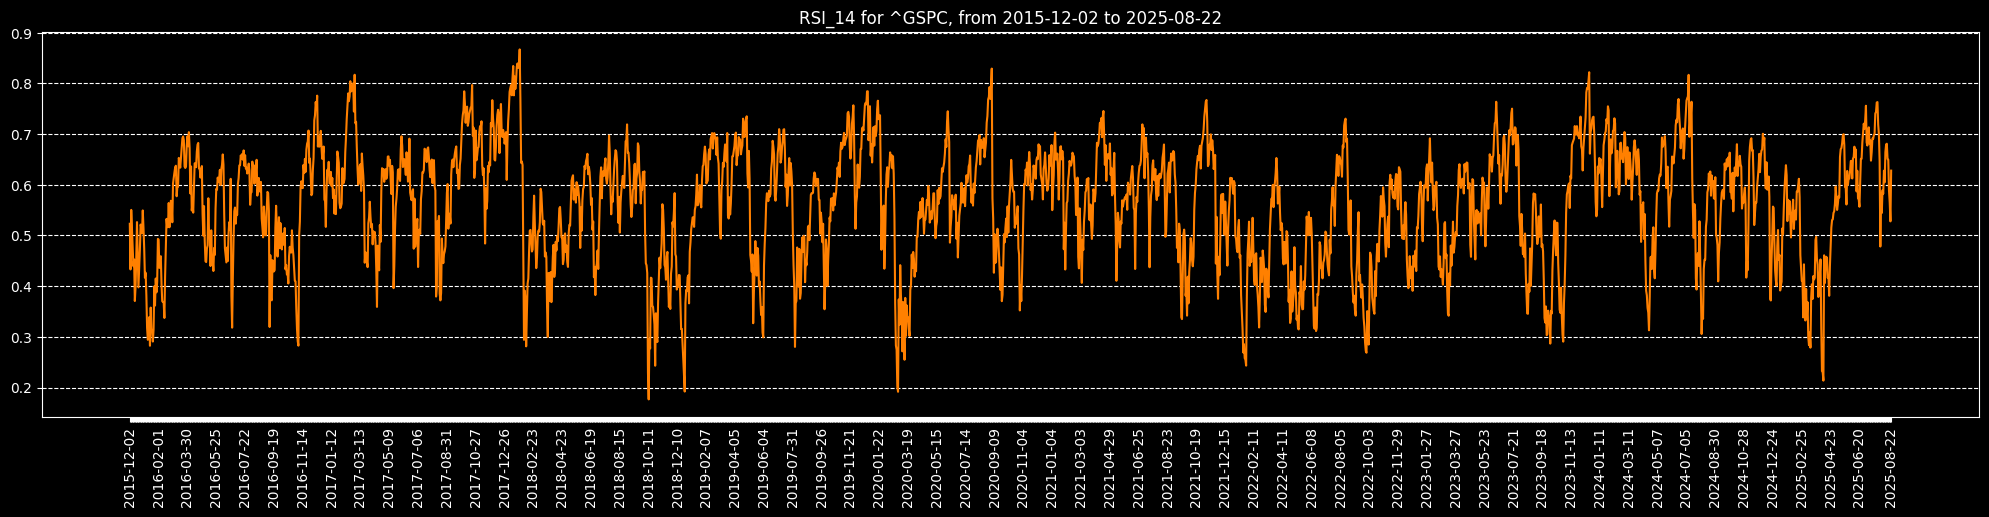

In [208]:
feature = "RSI_14"
feature_index = features.index(feature)

fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, data_scaled_features[:, feature_index], color=config["plots"]["color_actual"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]

for i in range(num_data_points):
    # Always include the last data point
    if i == num_data_points - 1:
        xticks_labels.append(data_dates[i])
    # Include every xticks_interval-th point, but avoid ticks too close to the end
    elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)

xticks_indices = np.arange(0, len(xticks_labels))
plt.xticks(xticks_indices, xticks_labels, rotation="vertical")

plt.title(f"{feature} for {config["yfinance"]["symbol"]}, {display_date_range}")
plt.grid(axis="y", linestyle="--")

### Train/Val split

In [279]:
def make_windows(data, window_size):
    n_row = data.shape[0] - window_size
    X = np.array([data[i:i+window_size] for i in range(n_row)])
    y = np.array([data[i+window_size, 0] for i in range(n_row)])
    return X, y

X, y = make_windows(data_scaled_features, config["data"]["window_size"])
y = y.reshape(-1, 1)

X.shape, y.shape, X[0, :, 0], y[0]

((2460, 20, 7),
 (2460, 1),
 array([-1.35932525, -1.36724835, -1.34241413, -1.33465868, -1.3341975 ,
        -1.33662057, -1.34653923, -1.31839317, -1.29941126, -1.30273979,
        -1.30717511, -1.286667  , -1.28745528, -1.29588131, -1.27518059,
        -1.27036802, -1.27663944, -1.278635  , -1.27924704, -1.29653531]),
 array([-1.29390273]))

In [280]:
train_end = int(config["data"]["train_split_size"] * len(y))
val_end   = int((config["data"]["train_split_size"] + config["data"]["val_split_size"]) * len(y))

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print("First training window (closes only):", X_train[0, :, 0])
print("Target after it:", y_train[0])

(1722, 20, 7) (1722, 1)
(369, 20, 7) (369, 1)
(369, 20, 7) (369, 1)
First training window (closes only): [-1.35932525 -1.36724835 -1.34241413 -1.33465868 -1.3341975  -1.33662057
 -1.34653923 -1.31839317 -1.29941126 -1.30273979 -1.30717511 -1.286667
 -1.28745528 -1.29588131 -1.27518059 -1.27036802 -1.27663944 -1.278635
 -1.27924704 -1.29653531]
Target after it: [-1.29390273]


In [281]:
temp = df_features["Close"].to_numpy().reshape(-1, 1)

scaler_close = StandardScaler()
scaler_close.fit_transform(temp)

array([[-1.35932525],
       [-1.36724835],
       [-1.34241413],
       ...,
       [ 2.32312319],
       [ 2.30165118],
       [ 2.38276084]], shape=(2480, 1))

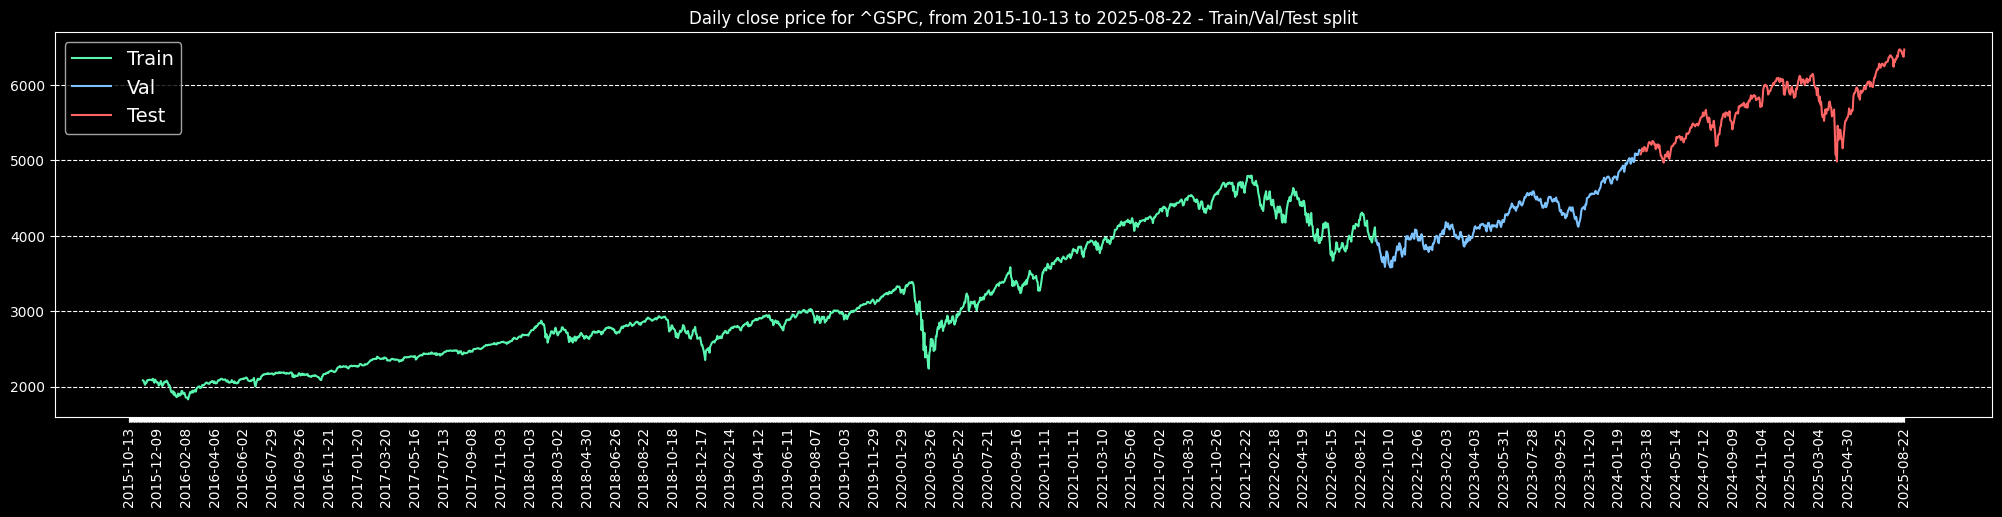

In [283]:
scaler_close = StandardScaler()
temp = scaler_close.fit_transform(df_features[["Close"]].values)

window_size = config["data"]["window_size"]

to_plot_data_y_train, to_plot_data_y_val, to_plot_data_y_test = np.array([None] * num_data_points), np.array([None] * num_data_points), np.array([None] * num_data_points)

to_plot_data_y_train[window_size : window_size + train_end] = scaler_close.inverse_transform(y_train).squeeze()
to_plot_data_y_val[window_size + train_end : window_size + val_end] = scaler_close.inverse_transform(y_val).squeeze()
to_plot_data_y_test[window_size + val_end : ] = scaler_close.inverse_transform(y_test).squeeze()


fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, to_plot_data_y_train, label = "Train", color=config["plots"]["color_train"])
plt.plot(data_dates, to_plot_data_y_val, label = "Val", color=config["plots"]["color_val"])
plt.plot(data_dates, to_plot_data_y_test, label = "Test", color=config["plots"]["color_test"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]
for i in range(num_data_points):
    if i == num_data_points - 1:
        xticks_labels.append(data_dates[i])
    elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Daily close price for {config["yfinance"]["symbol"]}, {display_date_range} - Train/Val/Test split")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


### Datasets and DataLoaders

In [291]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
dataset_train = TimeSeriesDataset(X_train, y_train)
dataset_val = TimeSeriesDataset(X_val, y_val)
dataset_test = TimeSeriesDataset(X_test, y_test)

print("Train data shape:", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape:", dataset_val.x.shape, dataset_val.y.shape)
print("Test data shape:", dataset_test.x.shape, dataset_test.y.shape)

dataset_train.x[:2, :, 0], dataset_train.y[0]

Train data shape: torch.Size([1722, 20, 7]) torch.Size([1722, 1])
Validation data shape: torch.Size([369, 20, 7]) torch.Size([369, 1])
Test data shape: torch.Size([369, 20, 7]) torch.Size([369, 1])


(tensor([[-1.3593, -1.3672, -1.3424, -1.3347, -1.3342, -1.3366, -1.3465, -1.3184,
          -1.2994, -1.3027, -1.3072, -1.2867, -1.2875, -1.2959, -1.2752, -1.2704,
          -1.2766, -1.2786, -1.2792, -1.2965],
         [-1.3672, -1.3424, -1.3347, -1.3342, -1.3366, -1.3465, -1.3184, -1.2994,
          -1.3027, -1.3072, -1.2867, -1.2875, -1.2959, -1.2752, -1.2704, -1.2766,
          -1.2786, -1.2792, -1.2965, -1.2939]]),
 tensor([-1.2939]))

In [292]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=config["training"]["batch_size"], shuffle=False)

## LSTM Model

$$
f_t = \sigma(W_{if} x_t + W_{hf} h_{t-1} + b_f) \\
i_t = \sigma(W_{ii} x_t + W_{hi} h_{t-1} + b_i) \\
\tilde{C}_t = \tanh(W_{iC} x_t + W_{hC} h_{t-1} + b_C) \\
o_t = \sigma(W_{io} x_t + W_{ho} h_{t-1} + b_o)
$$

In PyTorch, all the $W_{i*}$ (input -> gate) matrices are stacked together into weight_ih

All the $W_{h*}$ (hidden -> gate) are stacked together into weight_hh

$$
\begin{bmatrix}
f_t \\
i_t \\
\tilde{C}_t \\
o_t
\end{bmatrix}
=
\begin{bmatrix}
\sigma \\
\sigma \\
\tanh \\
\sigma
\end{bmatrix}
\Big(
W_{ih} x_t + W_{hh} h_{t-1} + b_{ih} + b_{hh}
\Big)
$$


In [295]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.linear_1 = nn.Linear(in_features=input_size, out_features=hidden_layer_size)
        self.relu = nn.ReLU()
        # batch_first = True makes input/output (batch_size, seq_len, feature_num) instead of (seq_len, batch_size, feature_num) 
        self.lstm = nn.LSTM(input_size=hidden_layer_size,
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=dropout)

        self.dropout = nn.Dropout(p=dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                 nn.init.zeros_(param)
            elif "weight_ih" in name:
                 nn.init.kaiming_normal_(param) # normal distribution scaled to preserve variance across layers
            elif "weight_hh" in name:
                 nn.init.orthogonal_(param) # preserves the gradient norm so it doesn't vanish/explode


    def forward(self, x):

        x = self.linear_1(x) # (batch, seq_len, num_features) -> (batch, seq_len, hidden_layer_size) 
        x = self.relu(x)

        # output has shape (batch, seq_len, hidden_layer_size). Hidden state from last LSTM layer, at every time step
        # h_n has shape (num_layers, batch, hidden_layer_size). Final hidden state for each layer, at the last time step
        # c_n has the same shape as h_n. Final cell state for each layer, at the last time step.
        output, (h_n, c_n) = self.lstm(x)

        x = h_n.transpose(0, 1).reshape(x.shape[0], -1) # (num_layers, batch, hidden_layer_size) -> (batch, num_layers*hidden_layer_size)

        x = self.dropout(x)

        x = self.linear_2(x) # (batch, output_size)
        return x.squeeze(-1)


## Model Training

In [ ]:
model = LSTMModel(input_size=config["model"]["input_size"], 
                  hidden_layer_size=config["model"]["lstm_size"], 
                  num_layers=config["model"]["num_lstm_layers"], 
                  dropout=config["model"]["dropout"])

model = model.to(config["training"]["device"])

loss_fn = nn.MSELoss()
optimizer = optim.AdamW(params = model.parameters(),
                        lr=config["training"]["learning_rate"],
                        betas=(0.9, 0.98),
                        eps=1e-9)

scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=config["training"]["scheduler_step_size"],
                                      gamma=0.1)

device = config["training"]["device"]


best_val_loss = float('inf')
best_epoch = 0
model_path = f"best_model_{config["yfinance"]["symbol"]}.pth"

for epoch in range(config["training"]["num_epoch"]):
    model.train()
    
    train_loss = 0.0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X) # (batch, 1) -> (batch,). Matches with y
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.detach().item()

    train_loss = train_loss / len(train_dataloader)

    model.eval()

    val_loss = 0.0
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)

            val_pred = model(X)
            val_loss += loss_fn(val_pred, y).item()


    val_loss = val_loss / len(val_dataloader)

    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), model_path)

    print(f"Epoch {epoch:03d}/{config["training"]["num_epoch"]} | train_loss: {train_loss:.6f} | val_loss: {val_loss:.6f} | lr: {current_lr:.6f}")

print(f"Best val loss: {best_val_loss} at epoch {best_epoch}")

## Model Evaluation

### Get Predictions

In [357]:
model.load_state_dict(torch.load(model_path))

train_preds_list = []
val_preds_list = []

train_eval_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False) # no shuffle

with torch.inference_mode():
    for X, y in train_eval_dataloader:
        X, y = X.to(device), y.to(device)

        train_pred = model(X)
        train_preds_list.append(train_pred)


    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)

        val_pred = model(X)
        val_preds_list.append(val_pred)

train_preds = torch.cat(train_preds_list).cpu().detach().numpy()
val_preds = torch.cat(val_preds_list).cpu().detach().numpy()

### Plot Predictions

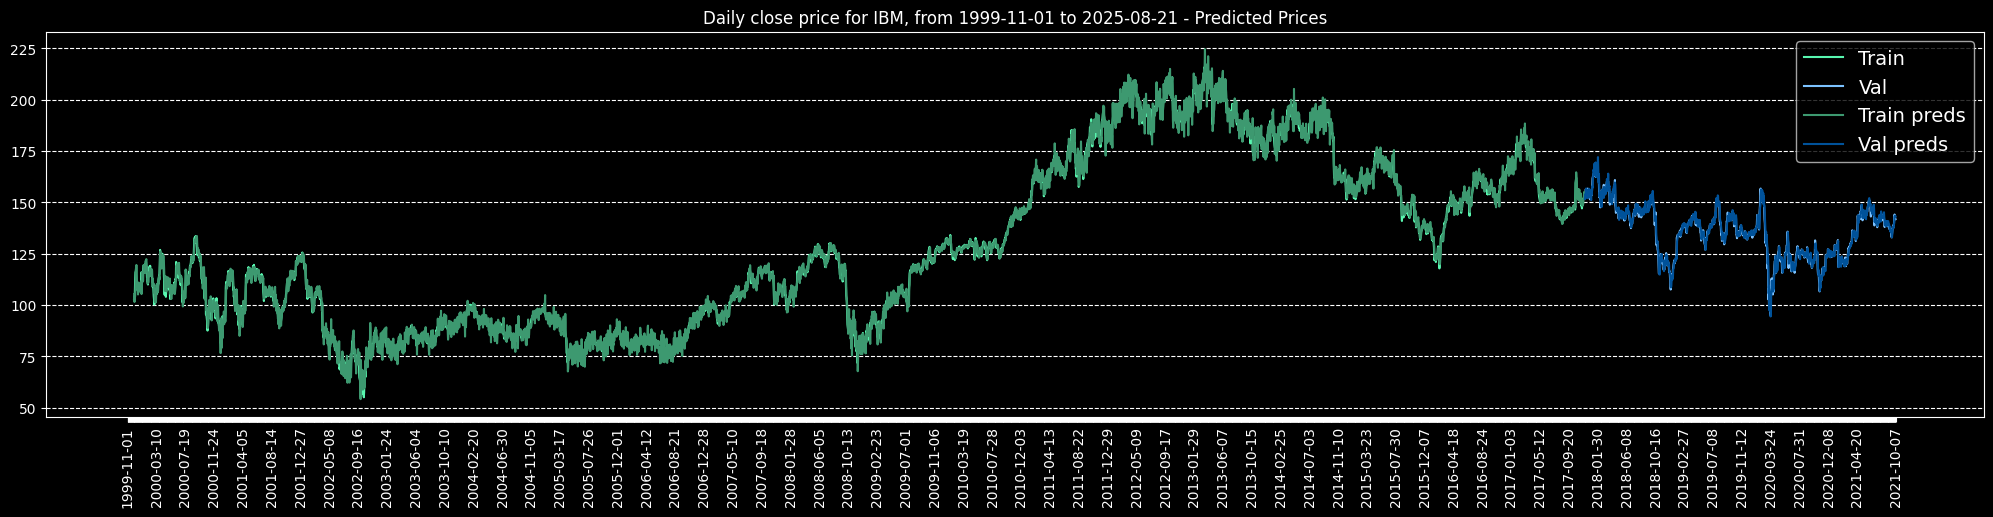

In [358]:
window_size = config["data"]["window_size"]


to_plot_y_train_preds = np.array([None] * num_data_points)
to_plot_y_val_preds = np.array([None] * num_data_points)

to_plot_y_train_preds[window_size : window_size + train_end] = scaler.inverse_transform(train_preds)
to_plot_y_val_preds[window_size + train_end : window_size + val_end] = scaler.inverse_transform(val_preds)


fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, to_plot_data_y_train, label = "Train", color=config["plots"]["color_train"])
plt.plot(data_dates, to_plot_data_y_val, label = "Val", color=config["plots"]["color_val"])

plt.plot(data_dates, to_plot_y_train_preds, label = "Train preds", color=config["plots"]["color_pred_train"])
plt.plot(data_dates, to_plot_y_val_preds, label = "Val preds", color=config["plots"]["color_pred_val"])


xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]

num_pred_data_points = num_data_points - len(y_test)

for i in range(num_pred_data_points):
    if i == num_pred_data_points - 1:
        xticks_labels.append(data_dates[i])
    elif i % xticks_interval == 0 and (num_pred_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range} - Predicted Prices")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


### Zoom in on Val Preds

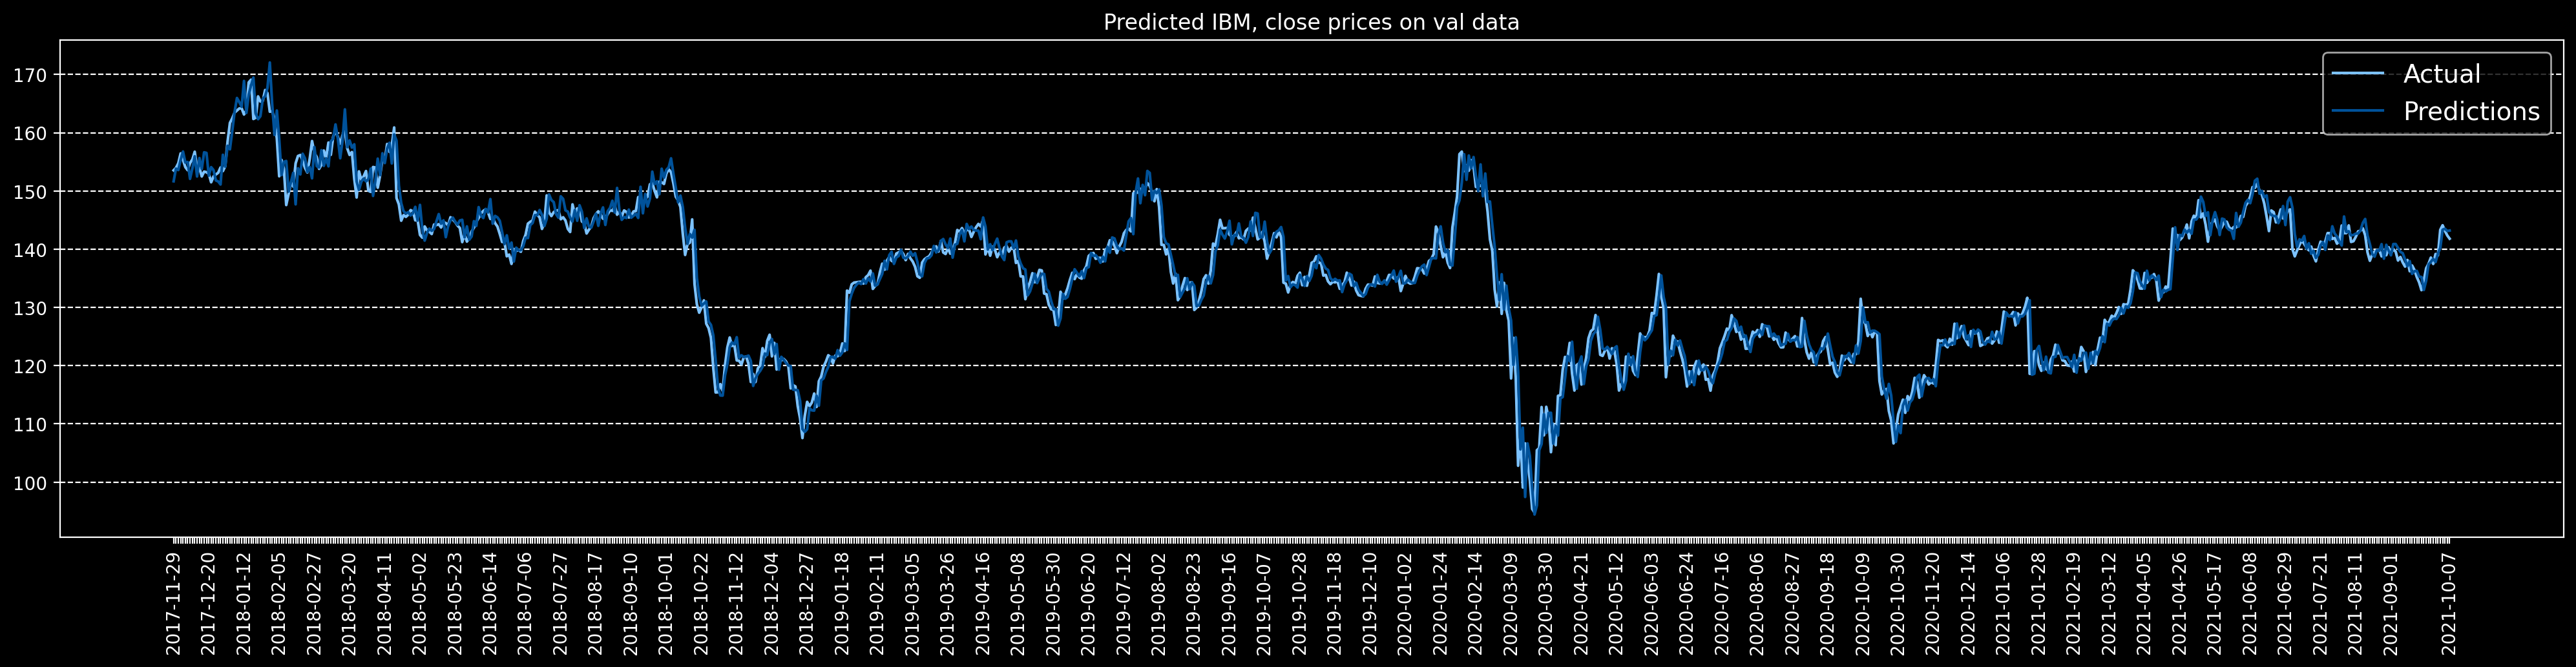

In [359]:
y_val_preds = scaler.inverse_transform(val_preds)
y_val_only = scaler.inverse_transform(y_val)

data_dates_val = data_dates[window_size + train_end : window_size + val_end]

fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_val, y_val_only, label = "Actual", color=config["plots"]["color_val"])
plt.plot(data_dates_val, y_val_preds, label = "Predictions", color=config["plots"]["color_pred_val"])


xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"] // 6

num_val_data_points = len(data_dates_val)

for i in range(num_val_data_points):
    if i == num_val_data_points - 1:
        xticks_labels.append(data_dates_val[i])
    elif i % (xticks_interval) == 0 and (num_val_data_points - i) > (xticks_interval):
        xticks_labels.append(data_dates_val[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Predicted {config["alpha_vantage"]["symbol"]}, close prices on val data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


### Predictions on Test Data

In [360]:
test_preds_list = []
test_loss = 0.0

x = torch.tensor(X_test, dtype=torch.float).unsqueeze(-1)
x = x.to(config["training"]["device"])

model.eval()
for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)

    test_pred = model(X)
    test_preds_list.append(test_pred)
    test_loss += loss_fn(test_pred, y).item()

test_loss = test_loss / len(test_dataloader)

test_preds = torch.cat(test_preds_list).cpu().detach().numpy()
print(f"Test loss: {test_loss:.6f}")

Test loss: 0.021485


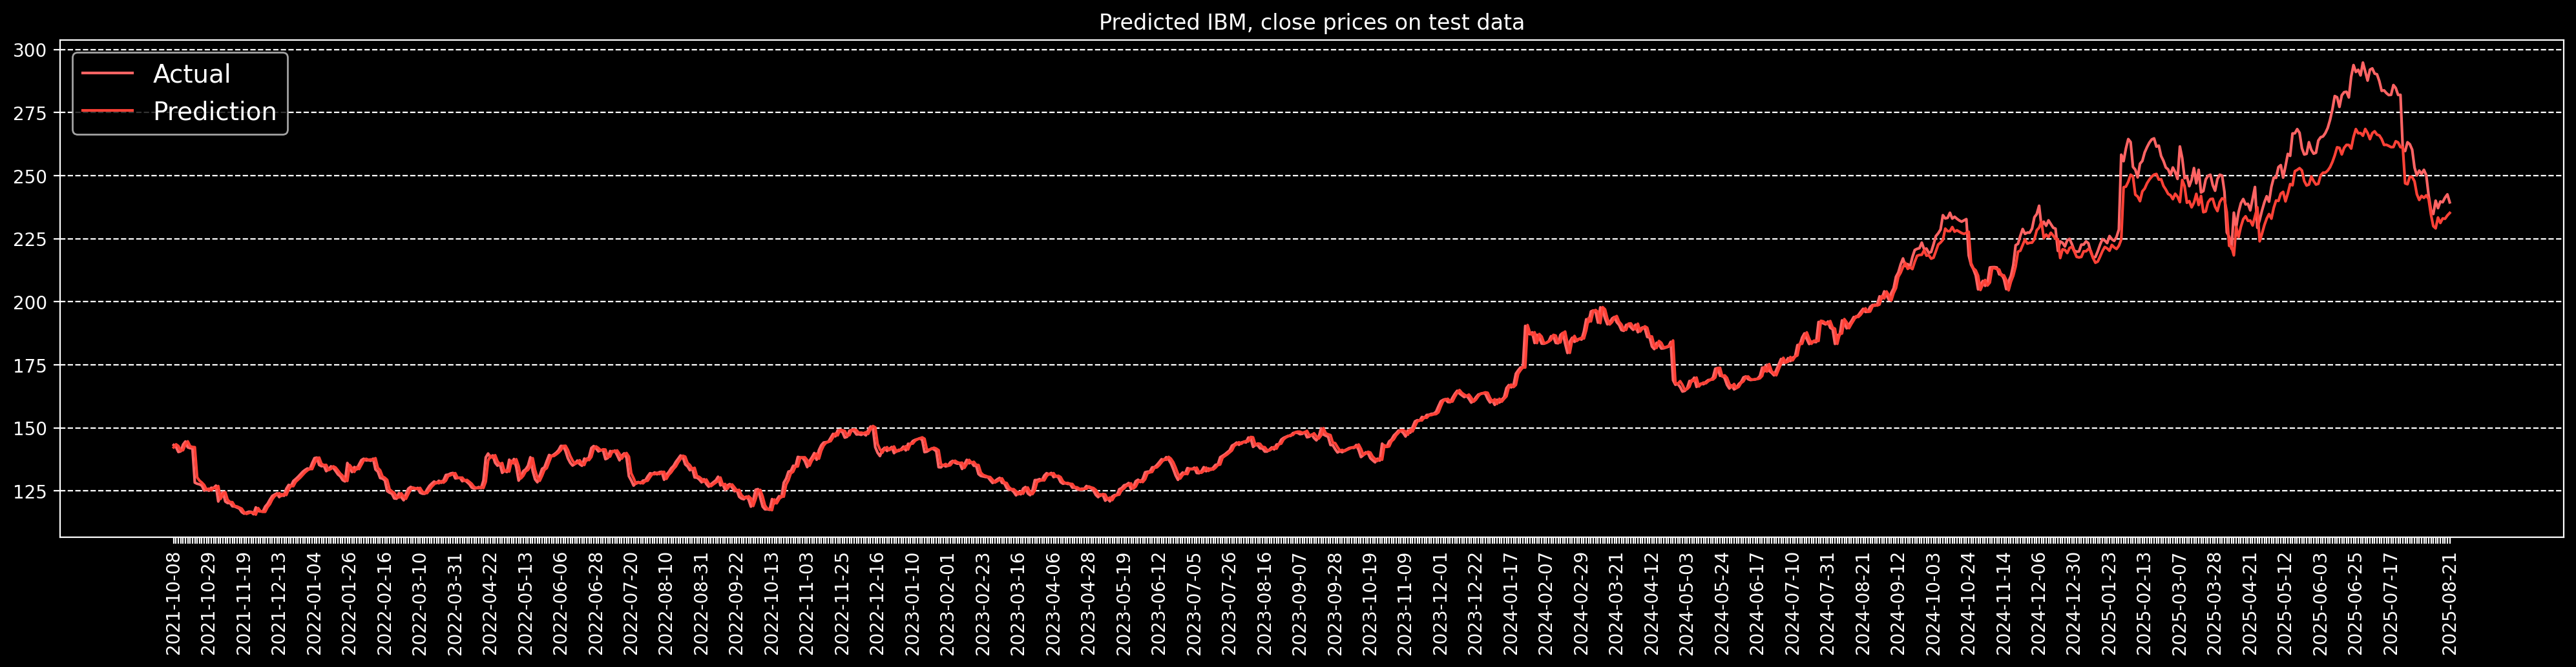

In [361]:
y_test_only = scaler.inverse_transform(y_test)
y_test_preds = scaler.inverse_transform(test_preds)

data_dates_test = data_dates[window_size + val_end:]


fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_test, y_test_only, label = "Actual", color=config["plots"]["color_test"])
plt.plot(data_dates_test, y_test_preds, label = "Prediction", color=config["plots"]["color_pred_test"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"] // 6

num_test_data_points = len(data_dates_test)

for i in range(num_test_data_points):
    if i == num_test_data_points - 1:
        xticks_labels.append(data_dates_test[i])
    elif i % (xticks_interval) == 0 and (num_test_data_points - i) > (xticks_interval):
        xticks_labels.append(data_dates_test[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Predicted {config["alpha_vantage"]["symbol"]}, close prices on test data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)

In [362]:
y_test_tensor = torch.tensor(y_test)
test_preds_tensor = torch.tensor(test_preds)

true_dir = torch.sign(y_test_tensor[1:] - y_test_tensor[:-1])
pred_dir = torch.sign(test_preds_tensor[1:] - test_preds_tensor[:-1])

weights = torch.abs(y_test_tensor[1:] - y_test_tensor[:-1])

weighted_correct = (true_dir == pred_dir).float() * weights
weighted_accuracy = weighted_correct.sum() / weights.sum()

print(f"Weighted Directional Accuracy: {100*weighted_accuracy:.2f}%")

Weighted Directional Accuracy: 53.29%


#### Zoom in

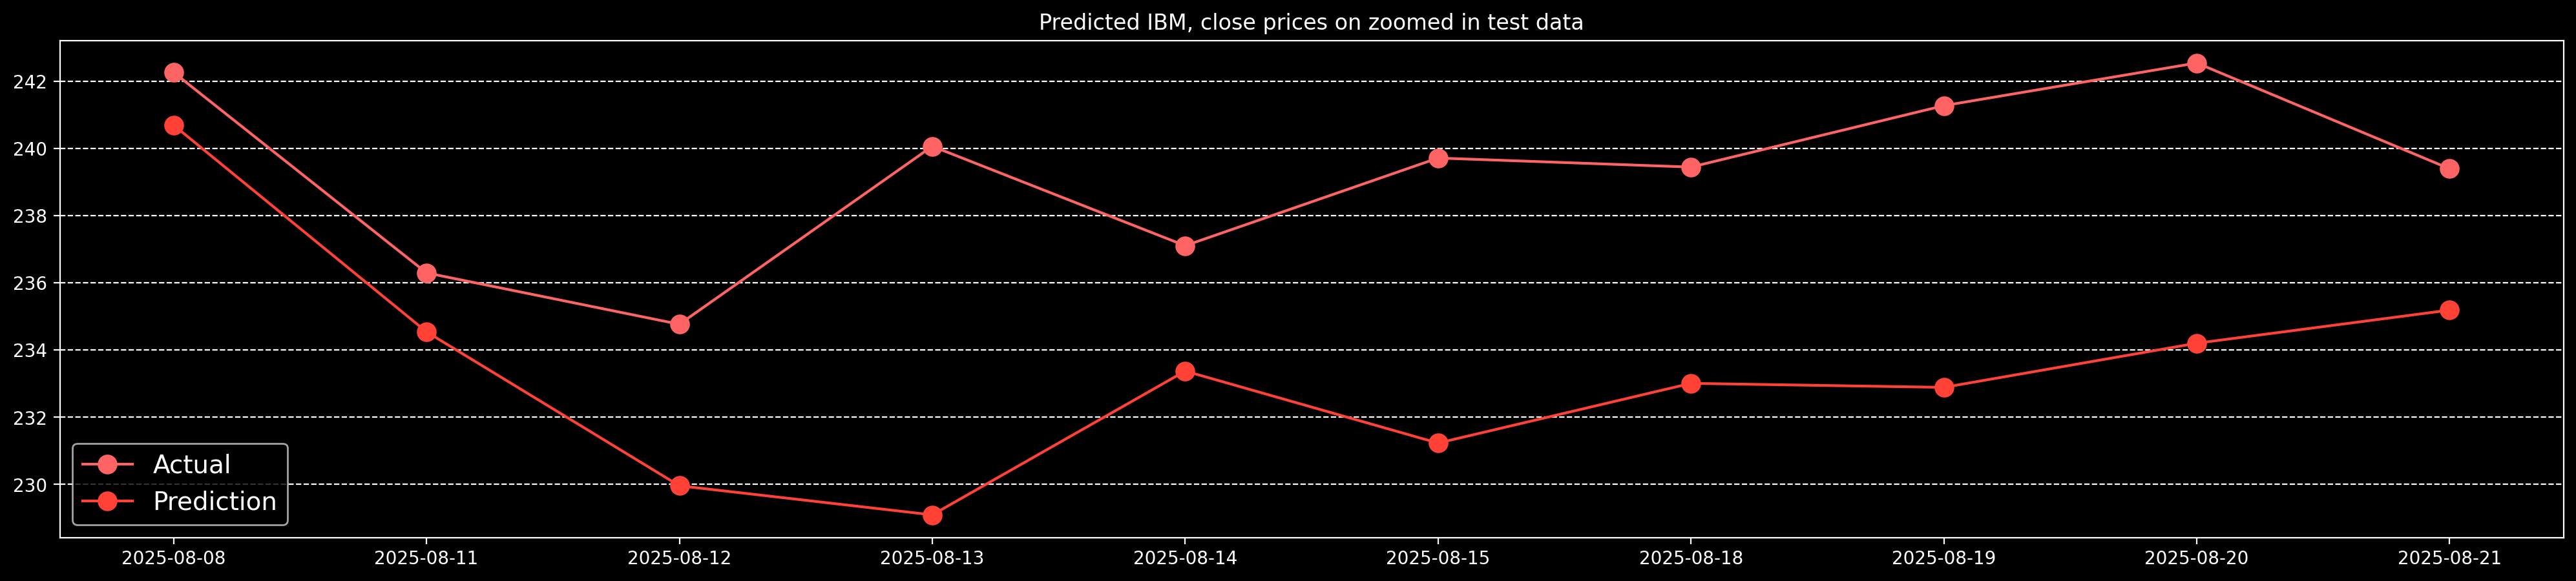

In [363]:
y_test_zoomed = y_test_only[-10:]
y_test_preds_zoomed = y_test_preds[-10:]

data_dates_test_zoomed = data_dates[-10:]


fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_test_zoomed, y_test_zoomed, label = "Actual", color=config["plots"]["color_test"], marker="o", markersize=10)
plt.plot(data_dates_test_zoomed, y_test_preds_zoomed, label = "Prediction", color=config["plots"]["color_pred_test"], marker="o", markersize=10)


plt.title(f"Predicted {config["alpha_vantage"]["symbol"]}, close prices on zoomed in test data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)